In [1]:
# Kaggle COMPETITION bootstrapping
COMPETITION_NAME = 'otto-recommender-system'

!pip install -qq fastai
!pip install -qq kaggle

from fastai.imports import *
np.set_printoptions(linewidth=130)

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# get competition data
if iskaggle:
    path = Path('../input/'+COMPETITION_NAME)
else:
    DOWNLOADS = Path('downloads')
    import zipfile,kaggle
    path = DOWNLOADS / COMPETITION_NAME
    if not path.is_dir():
        kaggle.api.competition_download_cli(COMPETITION_NAME, path=DOWNLOADS)
        zipfile.ZipFile(f'{path}.zip').extractall(path)
print('done')

done


### trimming the beast dataset

In [2]:
path

Path('downloads/otto-recommender-system')

In [ ]:
!ls {path}

In [5]:
!du -sh {path}/*

176M	downloads/otto-recommender-system/sample_submission.csv
384M	downloads/otto-recommender-system/test.jsonl
1.1G	downloads/otto-recommender-system/train-small.jsonl


In [ ]:
!wc -l {path}/train.jsonl

12899779 downloads/otto-recommender-system/train.jsonl


holy wacamoli! 12M lines! let's remove like 90%

In [3]:
from tqdm.auto import tqdm

In [10]:
with open(path/'train.jsonl') as f:
    with open(path/'train-small.jsonl', 'w') as fout:
        for i, line in tqdm(enumerate(f.readlines())):
            if not i % 10 == 0: continue
            fout.write(line)

0it [00:00, ?it/s]

In [13]:
!du -sh {path}/*

176M	downloads/otto-recommender-system/sample_submission.csv
384M	downloads/otto-recommender-system/test.jsonl
1.1G	downloads/otto-recommender-system/train-small.jsonl
11G	downloads/otto-recommender-system/train.jsonl


In [15]:
!rm {path/'train.jsonl'}

rm: cannot remove 'downloads/otto-recommender-system/train.jsonl': No such file or directory


In [16]:
!du -sh {path}/*

176M	downloads/otto-recommender-system/sample_submission.csv
384M	downloads/otto-recommender-system/test.jsonl
1.1G	downloads/otto-recommender-system/train-small.jsonl


done!

### Data loading

In [4]:
df = pd.read_json(path/'train-small.jsonl', lines=True)

In [5]:
df.set_index('session', drop=True, inplace=True)

In [6]:
df.head(3)

,events
session,
0,"[{'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'}, {'aid': 1563459, 'ts': 1659304904511, 'type': 'clicks'}, {'aid': 1309446, 'ts': 1659367439426, 'type': 'clicks'}, {'aid': 16246, 'ts': 1659367719997, 'type': 'clicks'}, {'aid': 1781822, 'ts': 1659367871344, 'type': 'clicks'}, {'aid': 1152674, 'ts': 1659367885796, 'type': 'clicks'}, {'aid': 1649869, 'ts': 1659369893840, 'type': 'carts'}, {'aid': 461689, 'ts': 1659369898050, 'type': 'carts'}, {'aid': 305831, 'ts': 1659370027105, 'type': 'orders'}, {'aid': 461689, 'ts': 1659370027105, 'type': 'orders'}, {'aid': 362233, 'ts': 1659370064..."
10,"[{'aid': 271630, 'ts': 1659304800151, 'type': 'clicks'}, {'aid': 967918, 'ts': 1660941383175, 'type': 'clicks'}, {'aid': 218627, 'ts': 1660941816696, 'type': 'clicks'}, {'aid': 766870, 'ts': 1660987307792, 'type': 'clicks'}, {'aid': 1071033, 'ts': 1661633415563, 'type': 'clicks'}, {'aid': 226954, 'ts': 1661633426190, 'type': 'clicks'}]"
20,"[{'aid': 817105, 'ts': 1659304800357, 'type': 'clicks'}, {'aid': 1539165, 'ts': 1659304816128, 'type': 'clicks'}, {'aid': 1194447, 'ts': 1660492223917, 'type': 'clicks'}, {'aid': 1726487, 'ts': 1661288846529, 'type': 'clicks'}, {'aid': 1099451, 'ts': 1661350978602, 'type': 'clicks'}, {'aid': 929999, 'ts': 1661350994694, 'type': 'clicks'}, {'aid': 1099451, 'ts': 1661350999891, 'type': 'clicks'}]"


In [7]:
# Let's look at an example session and print out some basic info
from datetime import timedelta

example_session = df.iloc[0].item()

print(f'This session was {len(example_session)} actions long \n')
print(f'The first action in the session: \n {example_session[0]} \n')


time_elapsed = example_session[-1]["ts"] - example_session[0]["ts"]
print(f'The first session elapsed: {str(timedelta(milliseconds=time_elapsed))} \n')

action_counts = {}
for action in example_session:
    action_counts[action['type']] = action_counts.get(action['type'], 0) + 1  
print(f'The first session contains the following frequency of actions: {action_counts}')

This session was 276 actions long 

The first action in the session: 
 {'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'} 

The first session elapsed: 27 days, 13:09:43.682000 

The first session contains the following frequency of actions: {'clicks': 255, 'carts': 17, 'orders': 4}


### EDA from baseline

In [8]:
action_counts_list, article_id_counts_list, session_length_time_list, session_length_action_list = ([] for i in range(4))
overall_action_counts = {}
overall_article_id_counts = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    
    actions = row['events']
    
    # Get the frequency of actions and article_ids
    action_counts = {}
    article_id_counts = {}
    for action in actions:
        action_counts[action['type']] = action_counts.get(action['type'], 0) + 1
        article_id_counts[action['aid']] = article_id_counts.get(action['aid'], 0) + 1
        overall_action_counts[action['type']] = overall_action_counts.get(action['type'], 0) + 1
        overall_article_id_counts[action['aid']] = overall_article_id_counts.get(action['aid'], 0) + 1
        
    # Get the length of the session
    session_length_time = actions[-1]['ts'] - actions[0]['ts']
    
    # Add to list
    action_counts_list.append(action_counts)
    article_id_counts_list.append(article_id_counts)
    session_length_time_list.append(session_length_time)
    session_length_action_list.append(len(actions))

  0%|          | 0/1289978 [00:00<?, ?it/s]

In [9]:
df['action_counts'] = action_counts_list
df['article_id_counts'] = article_id_counts_list
df['session_length_unix'] = session_length_time_list
df['session_length_hours'] = df['session_length_unix']*2.77778e-7  # Convert to hours
df['session_length_action'] = session_length_action_list

In [10]:
df.head(1)

,events,action_counts,article_id_counts,session_length_unix,session_length_hours,session_length_action
session,,,,,,
0,"[{'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'}, {'aid': 1563459, 'ts': 1659304904511, 'type': 'clicks'}, {'aid': 1309446, 'ts': 1659367439426, 'type': 'clicks'}, {'aid': 16246, 'ts': 1659367719997, 'type': 'clicks'}, {'aid': 1781822, 'ts': 1659367871344, 'type': 'clicks'}, {'aid': 1152674, 'ts': 1659367885796, 'type': 'clicks'}, {'aid': 1649869, 'ts': 1659369893840, 'type': 'carts'}, {'aid': 461689, 'ts': 1659369898050, 'type': 'carts'}, {'aid': 305831, 'ts': 1659370027105, 'type': 'orders'}, {'aid': 461689, 'ts': 1659370027105, 'type': 'orders'}, {'aid': 362233, 'ts': 1659370064...","{'clicks': 255, 'carts': 17, 'orders': 4}","{1517085: 1, 1563459: 1, 1309446: 1, 16246: 1, 1781822: 1, 1152674: 1, 1649869: 4, 461689: 3, 305831: 3, 362233: 3, 984597: 2, 803544: 1, 1110941: 1, 1190046: 2, 1760685: 1, 631008: 1, 1650637: 2, 313546: 1, 979517: 1, 351157: 1, 1062149: 1, 1157384: 1, 1841388: 1, 1469630: 1, 1110548: 3, 1650114: 1, 1604396: 1, 1009750: 1, 1800933: 1, 495779: 2, 394655: 1, 789245: 3, 366890: 1, 361317: 1, 1700164: 2, 1755597: 1, 784978: 3, 1171505: 1, 1521766: 2, 1725503: 1, 528847: 1, 1816325: 1, 1072782: 5, 173702: 2, 1407538: 1, 1629651: 1, 1768568: 1, 1318324: 2, 1840418: 1, 1813509: 4, 667924: 1, 122...",2380183682,661.162663,276


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

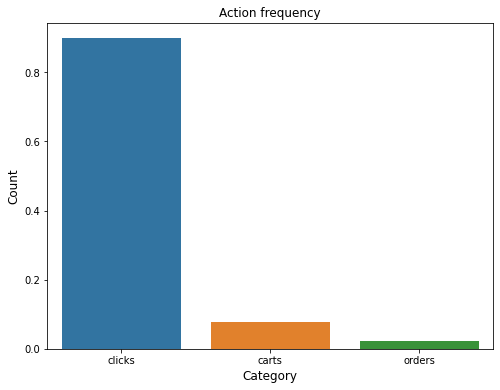

In [12]:
total_actions = sum(overall_action_counts.values())

plt.figure(figsize=(8,6))
sns.barplot(x=list(overall_action_counts.keys()), y=[i/total_actions for i in overall_action_counts.values()]);
plt.title('Action frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

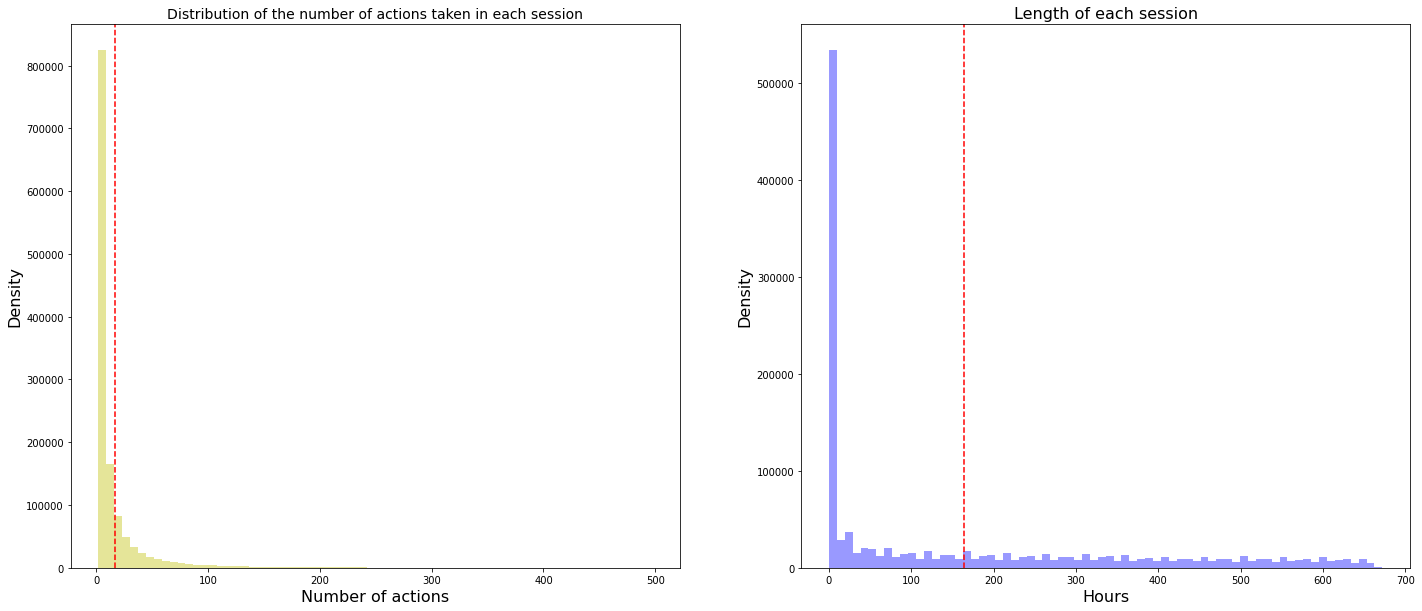

In [13]:
import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(1,2, figsize=(24, 10))

p = sns.distplot(df['session_length_action'], color="y", bins= 70, ax=ax[0], kde=False)
p.set_xlabel("Number of actions", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Distribution of the number of actions taken in each session", fontsize = 14)
p.axvline(df['session_length_action'].mean(), color='r', linestyle='--', label="Mean")

p = sns.distplot(df['session_length_hours'], color="b", bins= 70, ax=ax[1], kde=False)
p.set_xlabel("Hours", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Length of each session", fontsize = 16);
p.axvline(df['session_length_hours'].mean(), color='r', linestyle='--', label="Mean")

In [19]:
df.rename(columns = {'session_length_action': 'actions'}, inplace=True)

In [21]:
df.rename(columns = {'session_length_hours': 'hours'}, inplace=True)

In [23]:
import numpy as np

In [24]:
df['log_hours'] = np.log(df.hours)

<AxesSubplot:>

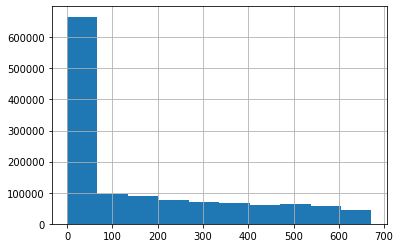

In [28]:
df.hours.hist()

In [33]:
print(f'{round(len(df[df["actions"]<10])/len(df),3)*100}% of the sessions had less than 10 actions')

63.9% of the sessions had less than 10 actions


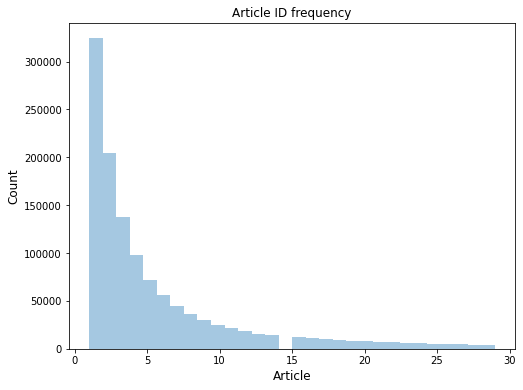

In [36]:
article_id_freq = list(overall_article_id_counts.values())
cut_off = [i for i in article_id_freq if i<30]

plt.figure(figsize=(8,6))
sns.distplot(cut_off, bins=30, kde=False);
plt.title(f'Article ID frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Article', fontsize=12);

In [38]:
### Look at the most interacted with articles ###
from heapq import nlargest
print(f'Frequency of most common articles: {sorted(list(overall_article_id_counts.values()))[-5:]} \n')
res = nlargest(5, overall_article_id_counts, key = overall_article_id_counts.get)
print(f'IDs for those common articles: {res}')

Frequency of most common articles: [10691, 11680, 11869, 12213, 13071] 

IDs for those common articles: [1460571, 485256, 108125, 29735, 1733943]


### some basic modeling from baseline

In [42]:
from collections import Counter

In [43]:
clicks_article_list = []
carts_article_list = []
orders_article_list = []

for i, row in tqdm(df.iterrows()):
    actions = row['events']
    for action in actions:
        if action['type'] == 'clicks':
            clicks_article_list.append(action['aid'])
        elif action['type'] == 'carts':
            carts_article_list.append(action['aid'])
        else:
            orders_article_list.append(action['aid'])

0it [00:00, ?it/s]

In [44]:
# Create dictionaries with articles and their frequencies
article_click_freq = Counter(clicks_article_list)
article_carts_freq = Counter(carts_article_list)
article_order_freq = Counter(orders_article_list)

In [45]:
# Get the 20 most frequent articles for each action
top_click_article = nlargest(20, article_click_freq, key = article_click_freq.get)
top_carts_article = nlargest(20, article_carts_freq, key = article_carts_freq.get)
top_order_article = nlargest(20, article_order_freq, key = article_order_freq.get) 

In [46]:
# Create a dict with this info
frequent_articles = {'clicks': top_click_article, 'carts':top_carts_article, 'order':top_order_article}

In [50]:
for action in ['clicks', 'carts', 'order']:
    print(f'Most frequent articles for {action}: {frequent_articles[action][:8]}')

Most frequent articles for clicks: [1460571, 108125, 29735, 485256, 1733943, 184976, 832192, 1502122]
Most frequent articles for carts: [485256, 152547, 33343, 166037, 1733943, 29735, 231487, 1022566]
Most frequent articles for order: [231487, 166037, 1733943, 1445562, 1629608, 1022566, 801774, 409620]


This baseline will use the fact that people will often interact with articles they have previouslt interacted with. The prediction will consist of the top 20 most frequent articles in the session. If there are less than 20 articles in the session the prediction will be padded with the most frequent articles in the training data as found above.

### test_df

In [39]:
! wc -l {path/'test.jsonl'}

1671803 downloads/otto-recommender-system/test.jsonl


In [40]:
test_df = pd.read_json(path/'test.jsonl', lines=True)

In [66]:
test_df.shape

(1671803, 2)

In [ ]:
import random
preds = []
for i, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    actions = row['events']
    article_id_list = []
    for action in actions:
        article_id_list.append(action['aid'])

    # Get 20 most common article ID for the session
    article_freq = Counter(article_id_list)
    top_articles = nlargest(20, article_freq, key = article_freq.get)

    # Pad with most popular items in training
    padding_size = (20 - len(top_articles))
    for action in ['clicks', 'carts', 'order']:
        top_articles_added = frequent_articles[action][:padding_size] + top_articles
        random.shuffle(top_articles_added)
        preds.append(" ".join([str(id) for id in top_articles_added]))

  0%|          | 0/1671803 [00:00<?, ?it/s]

### Submission

In [69]:
submission = pd.read_csv(path/'sample_submission.csv')
submission.head(1)

,session_type,labels
0,12899779_clicks,129004 126836 118524


In [70]:
submission.shape, len(preds)

((5015409, 2), 5015409)

In [71]:
submission['labels'] = preds

In [63]:
submission.head(6)

,session_type,labels
0,12899779_clicks,1460571 108125 29735 485256 1733943 184976 832192 1502122 554660 1603001 986164 322370 166037 231487 1236775 1196256 959208 620545 332654 95488
1,12899779_carts,485256 152547 33343 166037 1733943 29735 231487 1022566 1562705 832192 554660 544144 322370 1629608 986164 1083665 613493 1462420 332654 1460571
2,12899779_orders,231487 166037 1733943 1445562 1629608 1022566 801774 409620 1257293 544144 756588 1603001 450505 332654 29735 986164 1083665 125278 1116621 1025795
3,12899780_clicks,1460571 108125 29735 485256 1733943 184976 832192 1502122 554660 1603001 986164 322370 166037 231487 1236775 1196256 959208 620545 332654 95488
4,12899780_carts,485256 152547 33343 166037 1733943 29735 231487 1022566 1562705 832192 554660 544144 322370 1629608 986164 1083665 613493 1462420 332654 1460571
5,12899780_orders,231487 166037 1733943 1445562 1629608 1022566 801774 409620 1257293 544144 756588 1603001 450505 332654 29735 986164 1083665 125278 1116621 1025795


### send to kaggle!

In [72]:
# write submission csv
technique = 'populars first, then most common in session'
sub_filename = Path('subs')/(COMPETITION_NAME+'-'+technique+'-sub.csv')
submission.to_csv(sub_filename, index=False)

if not iskaggle:
    print('about to submit', sub_filename, 'to kaggle')
    input('continue?')
    ret = kaggle.api.competition_submit(sub_filename, technique, COMPETITION_NAME)
    print(ret)

about to submit subs/otto-recommender-system-populars first, then most common in session-sub.csv to kaggle


100%|██████████| 773M/773M [00:25<00:00, 32.2MB/s] 


Successfully submitted to OTTO – Multi-Objective Recommender System
